# LRP for regression: A simulation study

*This simulation study aims for a better understanding of the usage and interpretation of LRP for regression tasks.
The simulated dataset is intended to roughly imitate potential continuous ageing processes, specicifially in the brain. 
A 3D version of the pipeline below was applied on multi-model MRIs, reported in [Hofmann et al. (2021)](DOI).*

---
Simon M. Hofmann <br>
[*Max Planck Insitute for Human Cognitive and Brain Sciences, Leipzig, Germany*](https://www.cbs.mpg.de/employees/simonhofmann)<br>

<[firstname].[lastname][at]pm.me> <br>

`Last Update: 2021, Apri 8`

--- 

## Import packages and modules <a class="tocSkip">

In [1]:
# Notebook related
from IPython.display import display, Image

# XDLreg
from xdlreg.utils import cprint
from xdlreg.run_simulation import run_simulation
from xdlreg.SimulationData import make_pumpkin, get_pumpkin_set, PumpkinHead, split_simulation_data
from xdlreg.PumpkinNet import get_model_data, load_trained_model, model_for_data_exists, plot_training_process, plot_prediction
from xdlreg.LRP.create_heatmaps import p2relevance, create_relevance_dict

# In-built packages
import os
import inspect
import string

# External packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

%matplotlib inline

Using TensorFlow backend.


## Run the full simulation pipeline

In [2]:
# Adapt parameters if desired
run_simulation(path="..", n_samples=2000, uniform=False, target_bias=55., epochs=80, plot_n_heatmaps=20)

Run simulation on 2000 samples:

Train PumpkinNet:

No dataset found. Start creating it ...
Start creating the pumpkin dataset of 2021-04-08_17-38_N-2000_non-uniform55.0 ...
2021-04-08 17:38:38 | Creating whole dataset via parallel processing on 4 CPUs will take about: 0:05:39 [h:m:s] ...
Created 2000 pumpkins in 0:11:09 [hh:min:sec].

Processing time of _generate_data: 0:11:11 [h:m:s]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________

## Get the simulation data

In [3]:
# # Get Pumpkin dataset
model_name = "PumpkinNet_2000_non-uniform55.0"  # for setup above in run_simulation()

# # Alternatively use:
# model = load_trained_model()  # w/o arguments function allows to browse for trained model
# model_name = model.name

pumpkins_set = get_model_data(model_name=model_name, for_keras=False)

### Explore the data object

In [4]:
# What does the class PumpkinSet contain
print("Attributes of dataset object:", *[attri for attri in dir(pumpkins_set) if not attri.startswith("_")], sep="\n * .")  
cprint(f"\nDataset name: {pumpkins_set.name}", 'b')
print("Number of samples:", pumpkins_set.n_samples)
print("Age Distrubtion:", pumpkins_set.age_distribution)

Attributes of dataset object:
 * .age_bias
 * .age_distribution
 * .data
 * .data2numpy
 * .display_distrubtion
 * .is_uniform
 * .n_samples
 * .name
 * .save

Dataset name: 2021-04-08_17-38_N-2000_non-uniform55.0
Number of samples: 2000
Age Distrubtion: [66. 79. 59. ... 55. 57. 60.]


#### Data distrubtion

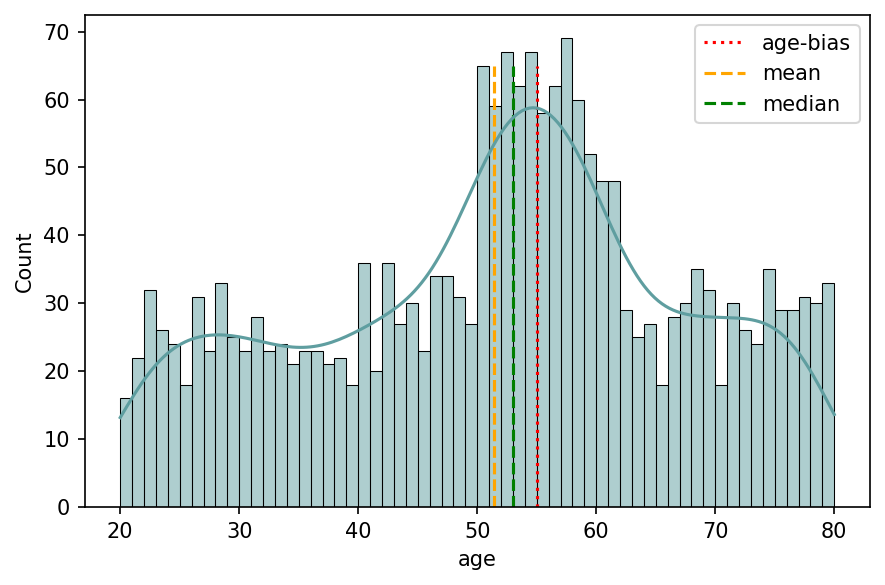

In [5]:
# Plot the distribution
pumpkins_set.display_distrubtion()

#### A sample pumpkin

Hi, I am PHbbL092693288 and I am 66.0 years old.
Number of atrophies: 330
Number of lesions: 26
Image.shape: (98, 98)


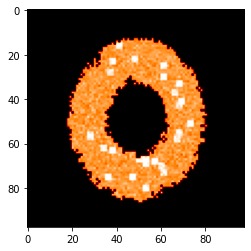

In [6]:
# # Take one pumpkin
phead = pumpkins_set.data[0]  # class PumpkinHead 

def introduce_yourself(pumpkin):
    cprint(f"Hi, I am {pumpkin.name} and I am {pumpkin.age} years old.", 'y')

introduce_yourself(phead)
print("Number of atrophies:", phead.n_atrophies)
print("Number of lesions:", phead.n_lesions)
print("Image.shape:", phead.pumpkin_brain.shape)
# class PumpkinHead also includes the position of the atrophies & lesions

# Plot the pumpkin
phead.exhibition()

#### How do they grow?
First we need a standard pumpkin. This is a blue-print (with some slight variation) for each instantiation of a *real* pumpkin

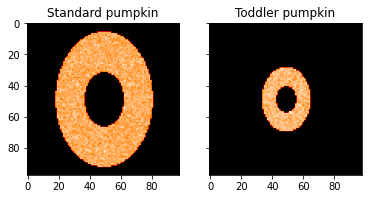

In [7]:
# print(inspect.getsource(make_pumpkin))  # explore the function behind the pumpkin blueprint

# Create standard pumpkin
standard_pumpkin = make_pumpkin(age=66)
standard_pumpkin_toddler = make_pumpkin(age=2)

# Plot it
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(standard_pumpkin, cmap="gist_heat")
ax1.set_title("Standard pumpkin")
ax2.imshow(standard_pumpkin_toddler, cmap="gist_heat")
ax2.set_title("Toddler pumpkin")
plt.show()

Note, we don't have *minors* in our current dataset. However, setting the `min_age` lower in `xdlreg.SimulationData.py` would also allow for '*developemental*' studies. That is, the size of a head is only a function of younger ages (< 20 years). For *adult pumpkins*, the head size is constant (+ random variation), ignoring the effect of *atrophies*.

We let the pumpkin grow/age within the class `PumpkinHead` (see below).

In [8]:
# Explore the class PumpkinHead 
# print(inspect.getsource(PumpkinHead))

Hi, I am Halloween senior and I am 77 years old.


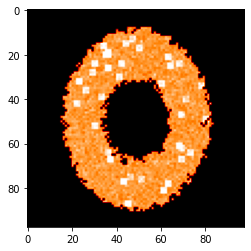

Hi, I am Halloween junior and I am 22 years old.


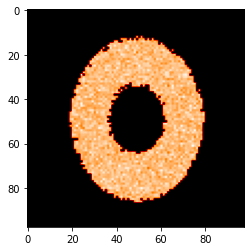

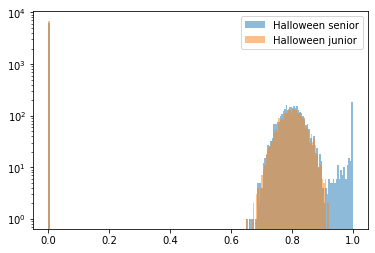

In [9]:
# Oldy
pumpy = PumpkinHead(age=77, name="Halloween senior")
introduce_yourself(pumpy)
pumpy.exhibition()

# Youngster
pumpster = PumpkinHead(age=22, name="Halloween junior")
introduce_yourself(pumpster)
pumpster.exhibition()

# Image intensities
_ = plt.hist(pumpy.pumpkin_brain.flatten(), bins=200, log=True, label=pumpy.name, alpha=.5)
_ = plt.hist(pumpster.pumpkin_brain.flatten(), bins=200, log=True, label=pumpster.name, alpha=.5)
plt.legend()
plt.show()

While *atrophies* lower the image values to zero at the boarder of the torus, *lesions* increase image values up until 1 within the body of the torus (*pumpkin*).

#### Number of lesions & atrophies
Both the numbers of lesions and atrophies are functions of age

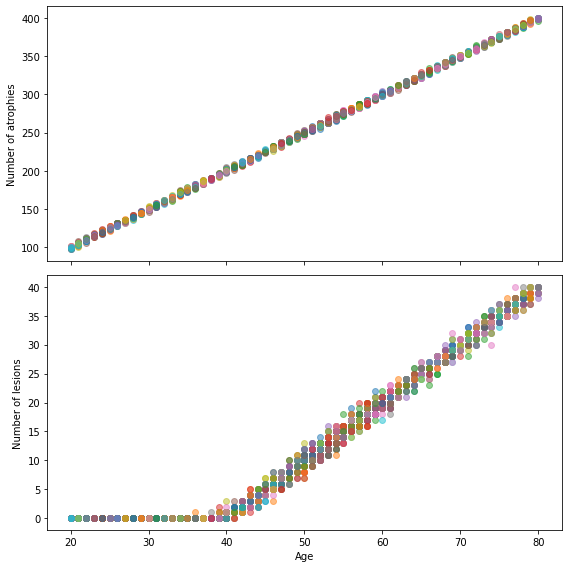

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
for pumpkin in pumpkins_set.data:
    ax1.plot(pumpkin.age, pumpkin.n_atrophies, "o", alpha=.5)
    ax2.plot(pumpkin.age, pumpkin.n_lesions, "o", alpha=.5)
ax1.set_ylabel("Number of atrophies")
ax2.set_xlabel("Age")
ax2.set_ylabel("Number of lesions")
plt.tight_layout()

The number of *atrophies* is linearly increasing with age. In contrast, the number of *lesions* is a non-linear step-function of age.

This functions could be modified, based on empirical findings, and more *ageing processes* could be modeled as well.

## Get the prediction model

Explore training process, and performance of the prediction model.

In [11]:
# Load model
model = load_trained_model(model_name=model_name)
# model = load_trained_model(model_name=model_for_data_exists(dataset_name=pumpkins_set.name, epochs=80))  # set correct epochs as above

# Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
__________

Network architecture starting from top to bottom. 

### Training process

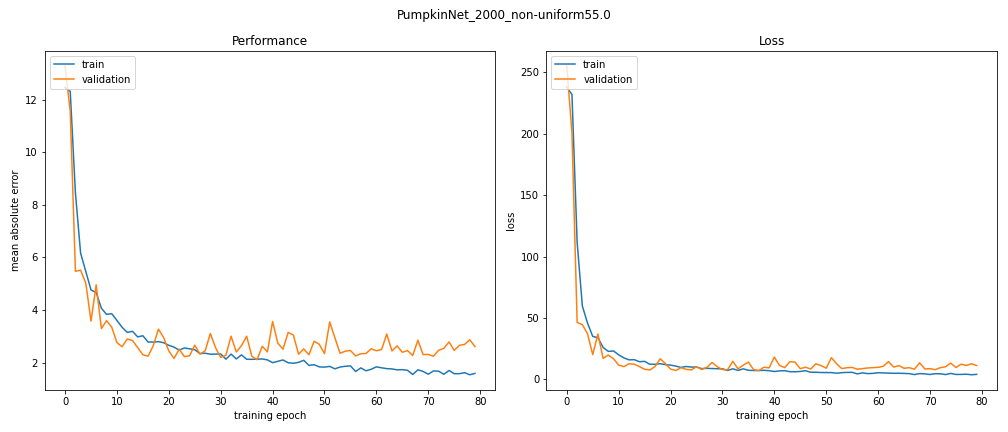

In [12]:
# Plot training process
plot_fn = plot_training_process(_model=model)
display(Image(filename=plot_fn))

### Model performance

Explore model performance on unseen test set.

In [13]:
# Prep data as model input
x, y = pumpkins_set.data2numpy(for_keras=True)
xtest, ytest = split_simulation_data(xdata=x, ydata=y, only_test=True)

# Predict on test set:
preds = model.predict(xtest)

# Model performance
perform = np.mean(np.abs(preds.squeeze() - ytest))
r = np.corrcoef(x=preds.flatten(), y=ytest)[0, 1]

cprint(f"\n{model.name} has a MAE of {perform:.2f} ({'R^2'}={r**2:.2f})\n", 'b')


PumpkinNet_2000_non-uniform55.0 has a MAE of 2.97 (R^2=0.96)



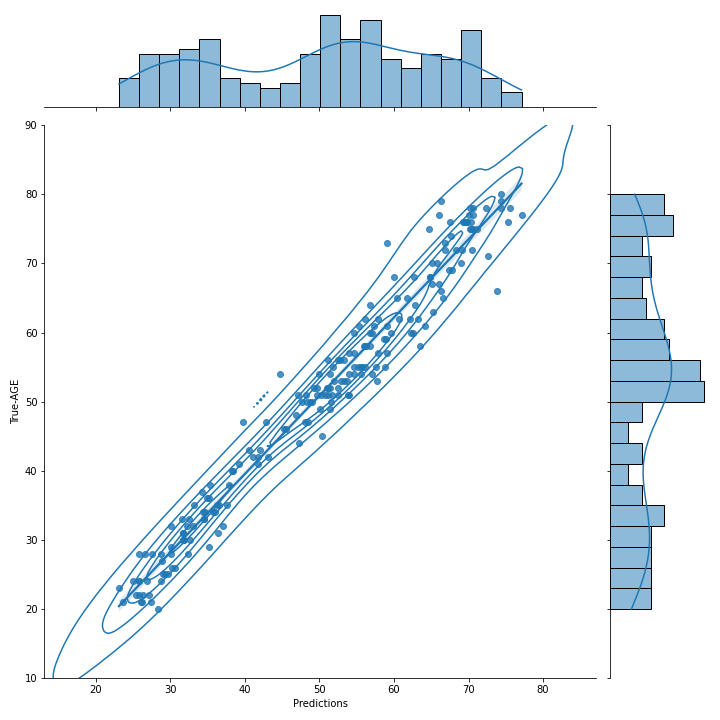

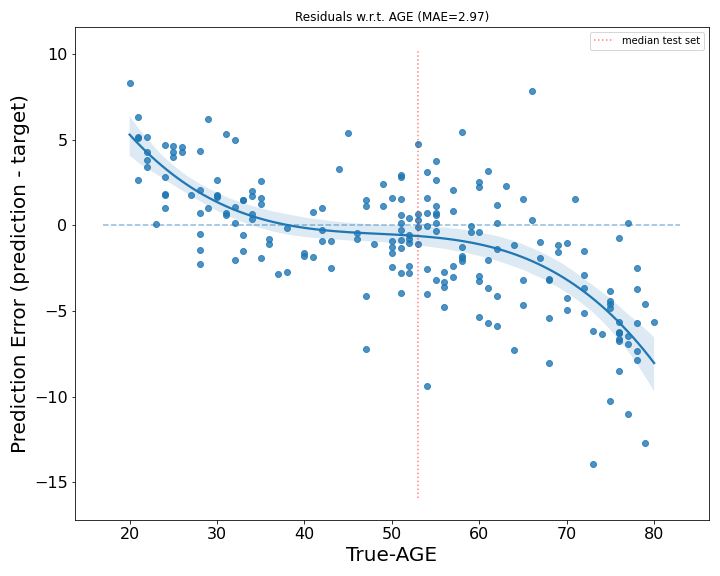

In [14]:
# Plot predictions 
plot_fns = plot_prediction(_model=model, xdata=xtest, ydata=ytest)

# Predictions vs true age
display(Image(filename=plot_fns[0]))

# # Plotted in this way:
# sns.jointplot(x=preds.squeeze(), y=ytest, kind="reg", height=10,
#               marginal_kws=dict(bins=int(round((ytest.max() - ytest.min()) / 3))),
#               xlim=(np.min(preds) - 10, np.max(preds) + 10),
#               ylim=(np.min(ytest) - 10, np.max(ytest) + 10)).plot_joint(
#     sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Predictions", "True-AGE")

# True age vs prediction-error:
display(Image(filename=plot_fns[1]))

The second plot shows the prediction error (prediction - true age) as a function of age. Models usually have a prediction bias towards the mean of the dataset. That is, younger samples (below the mean) are predicted as being older, older samples (above the mean) as being younger.  

## Apply LRP analysis on the regression model

LRP is used to analyse the model decisions. 

Here, the bias at the output layer of the model is important for the interpretation of the following relevance maps.

In [15]:
model_output_bias = model.layers[-1].get_weights()[1].item()

# Compare to the mean age in the dataset and to the prediction-'bias'
cprint(f"Bias at output layer in model: {model_output_bias:.2f}", 'b')  # this was set before training
print(f"Mean age of dataset is: {ytest.mean():.2f}")  # approx. the mean of the whole dataset
cprint(f"Mean prediction on test set is: {preds.mean():.2f}", 'y')

Bias at output layer in model: 51.42
Mean age of dataset is: 51.19
Mean prediction on test set is: 50.28


In [16]:
# Load relevance maps for tori in test set
relmaps = create_relevance_dict(model_name=model.name, subset="test")

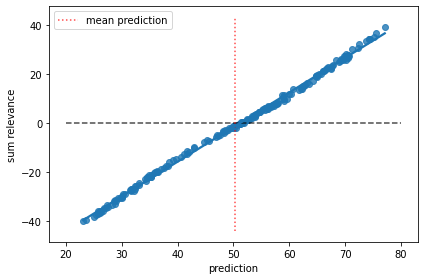

In [17]:
# Plot the sum-relevance per torus ('pumpkin') over the corresponding model predictions. 
ax = sns.regplot(x=preds, y=[rmap.sum() for rmap in relmaps])
plt.hlines(0, xmin=ytest.min(), xmax=ytest.max(), colors="black", ls="dashed", alpha=.7)
plt.vlines(x=preds.mean(), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors="red", ls="dotted", 
           alpha=.7, label="mean prediction")
plt.xlabel("prediction")
plt.ylabel("sum relevance")
plt.legend()
plt.tight_layout()

The summed *relevance* in a sample reflects the age-prediction of the model on this sample. Thus, negative *relevance* points towards a younger age, while positive to an older age.

### Individual LRP heatmaps

Similar to the summed *relevance* within a torus (*pumpkin*), also the sign and magnitude of individual pixel-wise *relevance* values reflect the model's interpretation of that area towards a certain age. The model aggregates the information over all pixels to a final prediction (i.e., summed *relevance*).

If `pointer=True` (in cell below), areas where *atrophies* occure are marked by *light-green* boxes. Arrows point to *lesions*.

LRP_S7_age-21.0_pred-26.2


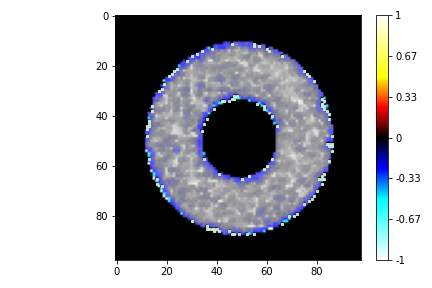

LRP_S8_age-22.0_pred-25.8


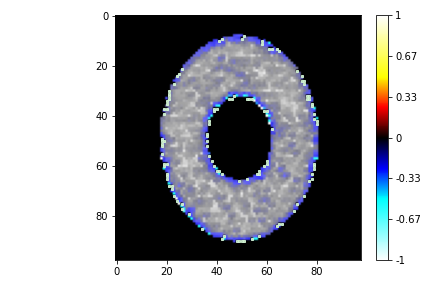

LRP_S12_age-28.0_pred-27.5


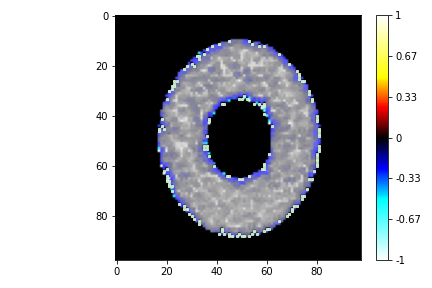

LRP_S1_age-29.0_pred-30.0


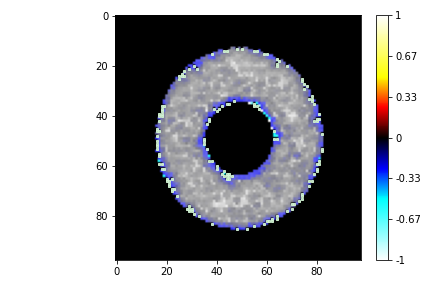

LRP_S6_age-33.0_pred-32.4


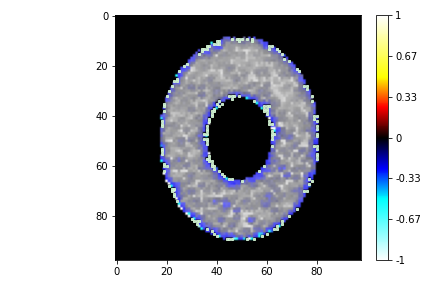

LRP_S11_age-33.0_pred-34.5


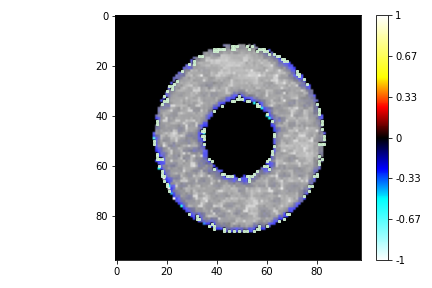

LRP_S4_age-38.0_pred-35.3


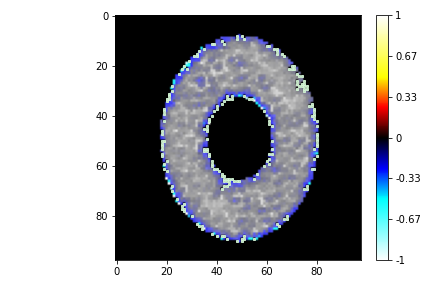

LRP_S13_age-38.0_pred-37.9


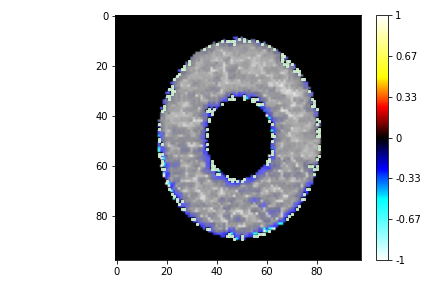

LRP_S2_age-51.0_pred-52.5


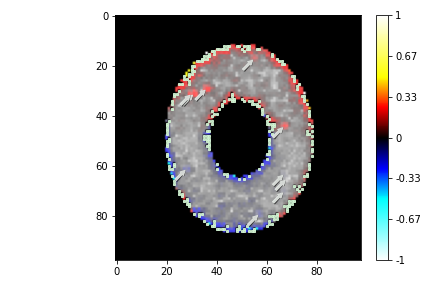

LRP_S10_age-51.0_pred-51.1


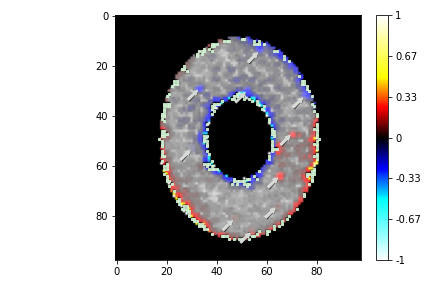

LRP_S16_age-51.0_pred-53.9


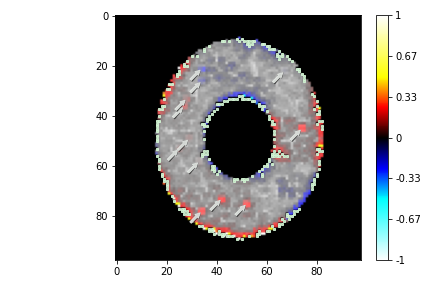

LRP_S19_age-52.0_pred-51.4


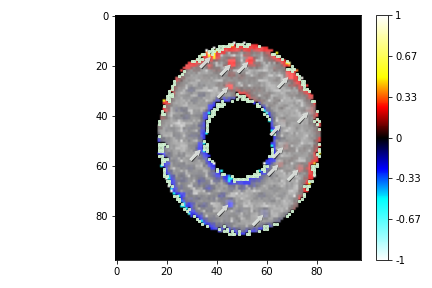

LRP_S18_age-53.0_pred-53.6


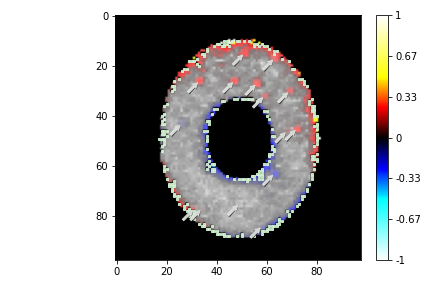

LRP_S17_age-62.0_pred-62.1


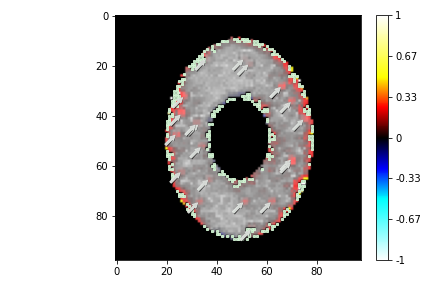

LRP_S9_age-65.0_pred-60.4


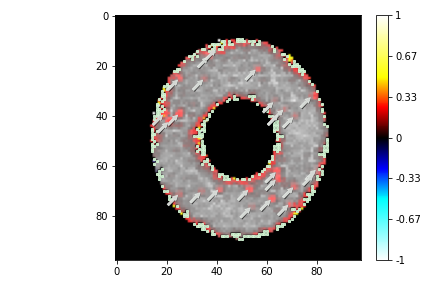

LRP_S15_age-65.0_pred-61.8


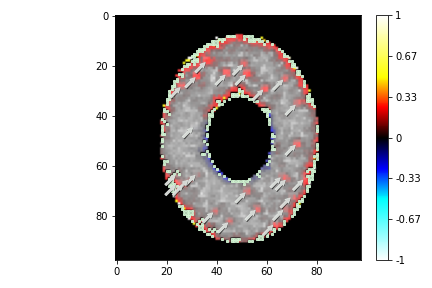

LRP_S3_age-70.0_pred-69.0


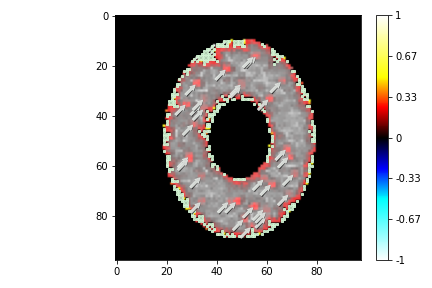

LRP_S5_age-75.0_pred-70.6


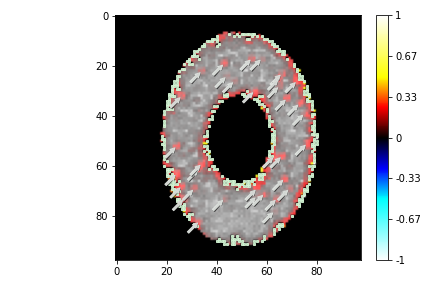

LRP_S14_age-76.0_pred-69.8


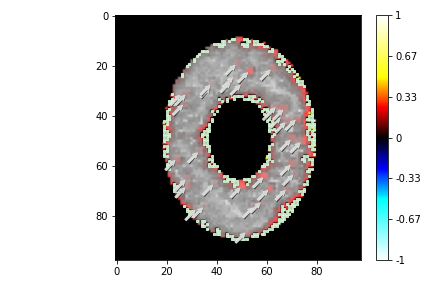

LRP_S0_age-76.0_pred-69.7


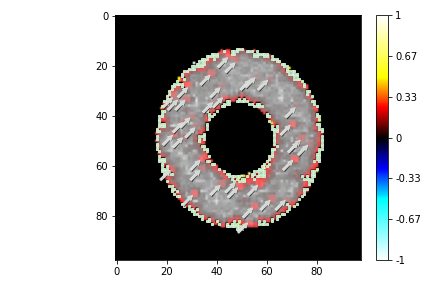

In [18]:
pointer = True  # toggle here, if pointer (not) requested.
# –––– –––– –––– –––– –––– –––– –––– –––– –––– –––– –––– –

# Get already computed LRP heatmaps of 20 subjects 
list_of_LRP_images = os.listdir(os.path.join(p2relevance(), model.name, "plots"))
list_of_LRP_images = [name for name in list_of_LRP_images if ((".png" in name) and (pointer is ("pointer" in name)))]  # remove non-*.png's
list_of_ages = [name.split("_")[2] for name in list_of_LRP_images]  # get age information from list
sorted_list_of_LRP_images = np.array(list_of_LRP_images)[np.argsort(list_of_ages)]  # sort list w.r.t. age

# Display LRP heatmaps
for LRP_image_file in sorted_list_of_LRP_images:
    if ".png" in LRP_image_file:
        cprint(LRP_image_file.rstrip("_pointer.png"), 'b')
        display(Image(filename=os.path.join(p2relevance(), model.name, "plots", LRP_image_file)))

The age of a torus (*pumpkin*) and the corresponding prediction by the model are indiciated in the filename on top of the plot.